**Input the date, radar, and the lowest bottom height of the ML for the investigated rain event and the used radar:**

In [1]:
event_date = '20170719'
radar_name = 'HNR'
event_ml = 2600 # in m unit

**Import**

In [2]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import wradlib as wrl
import warnings
import os
import scipy
import math
import RadarQC
import att_cor_tools_jy
from scipy.spatial import cKDTree as KDTree
warnings.filterwarnings("ignore")

**Read data :**

In [3]:
filename = os.path.join('%s_%s.nc' % (event_date,radar_name))
dwd_root = xr.open_dataset(filename)
dwd_sweep = xr.open_dataset(filename, group='sweep_1')
zh = dwd_sweep.DBZH;
zv = dwd_sweep.DBZV;
zdr = dwd_sweep.ZDR;
phidp = dwd_sweep.PHIDP; # should be already unfolded
rhv = dwd_sweep.URHOHV;

**Filter :**

In [4]:
# bins with std(ΦDP) >= 20 within a moving window of 5 bins are removed
phi_roll = phidp.rolling(range=5, center=True, min_periods=1)  
phi_std = phi_roll.std(ddof=0)
phidp = phidp.where((phi_std<20))

In [5]:
# remove data with Z < 5 dBZ
zh.values[zh.values<5] = np.nan

# remove isolated data as the number of valid points from the neighboring 8 bins <= 3 
# i.e, keep data if the number of valid points from the neighboring 8 bins > 4
zh = zh.where((~np.isnan(zh)) & (zh.pipe(RadarQC.area_n)>4))
phidp = phidp.where((~np.isnan(zh)) & (phidp.pipe(RadarQC.area_n)>4))

# make valid point consistent for diff. variables
zv = zv.where(~np.isnan(zh))
zdr = zdr.where(~np.isnan(zh))

**Patching data :**

In [6]:
# fill the holes by the mean of the surrounding data if more than 4 out of 8 bins are valid (3 times)
zh.values = RadarQC.patch(zh, 4, 3)   
zv.values = RadarQC.patch(zv, 4, 3)   
zdr.values = RadarQC.patch(zdr, 4, 3)   

**Update the filtered and smoothed data in the xarray**

In [7]:
dwd_sweep.DBZH.values = zh.values; dwd_sweep.DBZV.values = zv.values; dwd_sweep.ZDR.values = zdr.values;

**RHV noise correction :**

(Kai and Veli have another way to define NL, also can check with them)

$\begin{equation}
SNR (dB) = Z (dB) -20log(distance) - nl (dB) 
\tag{1}
\end{equation}$

$\begin{equation}
RHV_{corr} = RHV_{obs}(1+1/snr) 
\tag{2}
\end{equation}$

In [8]:
# continuously add an increment of 0.2 dB for noise level (nl) until the corrected rhv within the range (0.95, 1.01) occupy the largest proportion
dis = zh.range.values/1000 # m -> km
nl = np.linspace(-45,-30,76)
ratio = np.zeros_like(nl)
for ii in range(len(nl)):
    snr_c = zh.values.copy()-20.*np.log10(dis[None,None,:])-nl[ii]
    snr_l = 10**(0.1*snr_c) # dB -> linear
    rhv_c = rhv.values.copy()*(1.+1/snr_l)
    xx = rhv_c[(~np.isnan(snr_c)) & (~np.isnan(rhv_c))]
    yy = xx[(xx<1.01) & (xx>0.95)]
    ratio[ii] = len(yy)/len(xx)
print('Noise level =',nl[np.where(ratio==max(ratio))])

Noise level = [-35.8]


In [9]:
# noise correction using the above defined nl
NOISE_LEVEL = nl[np.where(ratio==max(ratio))]
snr_c = zh.values.copy()-20.*np.log10(dis[None,None,:])-NOISE_LEVEL
snr_l = 10**(0.1*snr_c)
rhv_c = rhv.values.copy()*(1.+1/snr_l)
dwd_sweep = dwd_sweep.assign({'SNR_C': (['time', 'azimuth', 'range'], snr_c)})
dwd_sweep = dwd_sweep.assign({'RHV_C': (['time', 'azimuth', 'range'], rhv_c)})
snr_c = dwd_sweep.SNR_C
rhv_c = dwd_sweep.RHV_C

**ΦDP smoothing :**

An iterative filtering technique for ΦDP following Hubbert and Bringi (1995) 

https://doi.org/10.1175/1520-0426(1995)012<0643:AIFTFT>2.0.CO;2

When the difference between observation and its mean within a moving window of 17 bins > 1.25 times the standard deviation of the same window, ΦDP is replaced by the mean. 

This filtering is iterated 5 times.
Then smoothed again by average with a moving window of 5 range bins 

In [10]:
phidp.values = RadarQC.smoother(phidp,zh,17,5,5,dim='range')  

**Subtract ΦDP offset :**

to get the total span of ΦDP

In [11]:
# determine the offset (phii) by the median of the first-five valid data along each ray
phidp_tmp = phidp.values.copy()
phidp_tmp[rhv_c.values<0.9] = np.nan
phii = np.median(RadarQC.shift_nan(phidp_tmp, np.nan, 2)[:,:,:5],axis = 2)
phisys = np.nanmedian(phii,axis=0) # systematic offset (phisys) defined as the median of phii over the whole event for each ray

# replace phii by phisys if their abs(diff.) > 5
mm,nn = np.where((np.abs(phii-phisys)>5) | (np.isnan(phii)))
phii[mm,nn] = phisys[nn] 

# subtract ΦDP offset to get dphi
dphi = phidp.values-phii[:,:,None]

# update dphi in the xarray
dphi[np.isnan(zh.values)] = np.nan
dwd_sweep.PHIDP.values = dphi
phidp = dwd_sweep.PHIDP

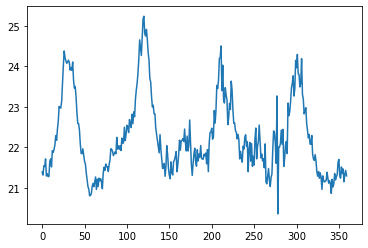

In [12]:
plt.plot(phisys)

Below the dotted line, the code lines are not implemented in POLARA (because I am not sure if it's worthy...)

.................................................................................................................................................................................................................................................................

**ΦDP bump correction :** 

Fill the gap in the ΦDP field using a linear interpolation (temporary ΦDP used for detecting ΦDP bumps) :

In [13]:
phi_tmp = phidp.copy()
# set the first bin as 0 if it is invalid for interpolation
mm,nn = np.where(np.isnan(phi_tmp.values[:,:,0])) 
phi_tmp.values[mm,nn,0] = 0

phi_tmp = phi_tmp.interpolate_na(dim="range", method="linear")
phi_tmp.values[np.isnan(zh.values)] = np.nan

KDP calculation (temporary KDP used for detecting ΦDP bumps) : 

In [14]:
dr = 0.25 # radial resolution
phidp_tmp, kdp_tmp = wrl.dp.process_raw_phidp_vulpiani(phi_tmp.values.copy(), dr, winlen=9) # window size as 9 bins, i.e., 2 km
kdp_tmp[np.isnan(phi_tmp.values)] = np.nan

Find ΦDP bump :

In [15]:
# only perform below the ML
zh_ml = zh.where((zh.z < event_ml)).values
phi_ml = phi_tmp.where((zh.z < event_ml)).values

In [16]:
# the interval compassing the segment with Z > 50 dBZ (HS) and negative KDP backside is regarded as the potential location of bump. 
# since those bumps always show a rapid increase of ΦDP in front, the start point of the interval is searched forward from the segment until ∆ΦDP between two consecutive bins < 1.5 
# the endpoint is the last bin with a negative value of KDP extending behind the segment. 

[l,m,n] = np.shape(zh)
bump_map = np.zeros((l,m,n))
diff = np.zeros((l,m,n))
diff[:,:,0:599] = np.diff(phi_ml, axis=2)

for i in range(l):
    for ii in range(m):
        hotspots = list(att_cor_tools_jy.identify_hotspot(zh_ml[i,ii], rhv_c[i,ii].values, len_threshold=500.)) # find the bins with Z > 50 dBZ
        hotspots = att_cor_tools_jy.repair_gapped_areas_jy(hotspots, zh_ml[i,ii], _threshold4repair_gap_max_range=5, _ret_missing_inds=[]) # concatenate HS if within 5 bins
        
        for j in range(len(hotspots)):
            # the length of HS should > 5 bins
            if ((len(hotspots[j])>=5) & (len(np.where(kdp_tmp[i,ii,hotspots[j]]<0)[0])>0)):
                xx = np.where(kdp_tmp[i,ii,hotspots[j][0]:hotspots[j][-1]+20]<0)[0]  # end point: searched till 20 bins behind the last negative KDP in the HS
                last_va = hotspots[j][0]+xx[-1] # end point
                
                if (hotspots[j][0]+xx[0]-len(xx)-15)>0: # start point: searched within 15 bins before the first bin of the HS
                    sear_p = hotspots[j][0]+xx[0]-len(xx)-15 # fist search point
                else:
                    sear_p = 0 # if less than 15 bins before the HS, set sear_p = 0
                    
                yy = np.where(diff[i,ii,sear_p:hotspots[j][0]]>1.5)[0] # find the point of ∆ΦDP > 1.5             
                if len(yy)>0: 
                    pre_va = sear_p+yy[0]+1  # start point
                else:
                    # if no bin with ∆ΦDP > 1.5, mark the first valid point as the start point
                    intx = np.where(~np.isnan(phi_ml[i,ii,sear_p:last_va+1]))[0]
                    pre_va = sear_p+intx[0]+1  #start point
                    
                    # give a new value from the nearest valid bin to the bin before the start point for interpolation 
                    pre_va_set = np.where(~np.isnan(phi_ml[i,ii,0:pre_va]))[0]
                    # if no vlid point found, set it as 0
                    if len(pre_va_set)<=1:
                        phidp.values[i,ii,pre_va-1] = 0
                    else:
                        phidp.values[i,ii,pre_va-1] = phidp.values[i,ii,pre_va_set[-1]]
         
                # mark 1 as bump bins in the bump_map field
                bump_map[i,ii,pre_va:last_va] = 1

# data within this interval are removed    
phidp.values[bump_map==1] = np.nan
bump_map[np.isnan(zh_ml)] = np.nan

.................................................................................................................................................................................................................................................................

Above the dotted line, the code lines are not implemented in POLARA

**Filling the bumps using a linear interpolation method :**

In [17]:
mm,nn = np.where(np.isnan(phidp.values[:,:,0]))
phidp.values[mm,nn,0] = 0
phidp = phidp.interpolate_na(dim="range", method="linear")
phidp.values[np.isnan(zh.values)] = np.nan
dwd_sweep.PHIDP.values = phidp.values

**Extract the data below BB :**

In [18]:
rawzh_ml = zh.where((zh.z < event_ml)).values
rawzv_ml = zv.where((zh.z < event_ml)).values
rawzdr_ml = zdr.where((zh.z < event_ml)).values
phi_ml = phidp.where((zh.z < event_ml)).values

**First guess attenuation correction for Z below the ML (for alpha derivation):**

In [19]:
alphah = 0.0927
alphav = 0.0712
belta = 0.021
zh_qc1 = rawzh_ml.copy(); zv_qc1 = rawzv_ml.copy(); 
zh_qc1 = zh_qc1 + phi_ml*alphah
zv_qc1 = zv_qc1 + phi_ml*alphav

**Derive the total span of ΦDP for attenuation correction along the entire ray :**

in this case, ∆ΦDP within the ML is multiplied by 3 for PIA calculation (phi_adj)

In [20]:
# read the file storing the bottom and top height of the ML for each time step
# it is different from the one you input at very beginning
# it is more precise and can change with time
ml = np.loadtxt('%s_%s_ml.txt' % (event_date, radar_name))
ml_bt = ml[:,0]
ml_tp = ml[:,1]

In [21]:
# ∆ΦDP within the ML is multiplied by 3
phi_bml = phidp.values.copy()
phi_iml = phidp.values.copy()
for i in range(0,l):
    phi_bml[i,zh.z>ml_tp[i]] = np.nan # keep ΦDP data below the top of the ML
    phi_iml[i,(zh.z>ml_tp[i]) | (zh.z<ml_bt[i])] = np.nan # keep ΦDP within the ML
    
phii_ml = np.median(RadarQC.shift_nan(phi_iml, np.nan, 2)[:,:,:5],axis = 2) # the first ΦDP value within the ML
dphi_iml = phi_iml-phii_ml[:,:,None] # ∆ΦDP within the ML
dphi_iml[(dphi_iml<0) | np.isnan((dphi_iml))] = 0 # set it as 0 if < 0
phi_adj = phi_bml + dphi_iml*2 # 3 times ∆ΦDP within the ML

for i in range(0,l):
    phi_adj[i] = RadarQC.ffill(phi_adj[i]) # fill the gap
phi_adj[(phi_adj<0) | (np.isnan(phi_adj))] = 0 # set it as 0 if < 0
phi_adj[np.isnan(zh.values)] = np.nan

**Attenuation correction for ZDR :**

using phi_adj

In [22]:
zdr_qc = zdr.values.copy()
zdr_qc = zdr_qc+phi_adj*belta
dwd_sweep = dwd_sweep.assign({'ZDR_att': (['time', 'azimuth', 'range'], zdr_qc)})
zdr_qc = dwd_sweep.ZDR_att

**Derive alpha for A estimates based on the ZDR slope with respect to ZH scan by scan :**

ZDR slope is estimated by fitting a straight line to the median ZDR values derived for each 1 dBZ interval of ZH between 25 dBZ and 40 dBZ.

In [23]:
coeff_afah = np.zeros((l)); coeff_afav = np.zeros((l)); slope_h = np.zeros((l))
stdz = np.zeros((l)); mz = np.zeros((l));
stdzdr = np.zeros((l)); mzdr = np.zeros((l));
zdr_tmp = []; zh_tmp = []; total_tmp = []

# interval of ZH between 25 dBZ and 40 dBZ
bins = np.linspace(25,40,16); t_bin = len(bins)-1; dt = bins[1]-bins[0]; midbin = bins[0:t_bin]+(dt/2)

# set the threshold of the number of vaild points, default alpha values of 0.09 and 0.07 for two channels.
thr_p = 20000; pafah_tmp = 0.09; pafav_tmp = 0.070; 

# to reduce resonance effects, ZDR is smoothed via averaging each bin with the neighboring 8 points
zdr_ml_tmp = zdr_qc.pipe(RadarQC.area_mean)
zdr_ml_tmp[np.isnan(zh_qc1)] = np.nan

# when the previous scan uses alpha values derived from very tropical DSDs (see below), 
# id_s indicates if the default values for the current scan are applied or not depending on the conditions
# applied for case (1), not applied for case (2) (see below)
id_s = 1

for i in range(l):
    # Z below the ML
    total_tmp = np.concatenate((zh_qc1[i,(~np.isnan(zdr_ml_tmp[i]))],total_tmp))
    n_total = len(total_tmp) # the number of vaild points
    
    # data below the ML satisfing the conditions for deriving ZDR slope
    # e.g., Z range and bins with ΦDP < 30 deg to reduce the uncertainties from attenuation
    zdr_tmp = np.concatenate((zdr_ml_tmp[i,(~np.isnan(zdr_ml_tmp[i])) & (rhv_c.values[i]>=0.8) & (dphi[i]<30) & (zh_ml[i]>25) & (zh_ml[i]<40)],zdr_tmp))
    zh_tmp = np.concatenate((zh_qc1[i,(~np.isnan(zdr_ml_tmp[i])) & (rhv_c.values[i]>=0.8) & (dphi[i]<30) & (zh_ml[i]>25) & (zh_ml[i]<40)],zh_tmp))
  
    # find the median ZDR for each Z interval
    idh = np.digitize(zh_tmp,bins)
    runmed_zdrh = np.asarray([np.nanmedian(zdr_tmp[idh==ii]) for ii in range(1,t_bin+1)])
    
    # only the medians derived with > 100 samples for each 1 dBZ interval are considered
    h_n = np.asarray([len(idh[idh==ii])<100 for ii in range(1,t_bin+1)])
    runmed_zdrh[np.array(np.where(h_n==1))] = np.nan
    
    # diff. of median ZDR between 2 intervals is used to identify any bump in the fitted points
    diff = np.diff(runmed_zdrh)
    neg_n = np.where(diff<0) # remove the point with negative diff.
    runmed_zdrh[neg_n] = np.nan
    
    # calculate std and mean of Z and ZDR
    # for ZDR, not all data are included because it is more sensentive to noise and attenuation bias
    stdz[i] = np.nanstd(total_tmp);mz[i] = np.nanmean(total_tmp)
    stdzdr[i] = np.nanstd(zdr_tmp);mzdr[i] = np.nanmean(zdr_tmp)

    # if the previous scan uses the most-tropical alpha values due to case (1), the default setting of alphas for the current scan is 0.09 abd 0.07
    if (pafah_tmp == 0.153) & (id_s==1):
        pafah_tmp = 0.09
        pafav_tmp = 0.07
    coeff_afah[i] = pafah_tmp 
    coeff_afav[i] = pafav_tmp    
    
    # case (1)
    # when one std of Z above its mean < 30 dBZ and one std of ZDR above its mean < 1.5 dB, alpha values of 0.153 and 0.147 are used (derived from very tropical DSDs)
    if ((stdz[i]+mz[i])<30) & ((stdzdr[i]+mzdr[i])<1.5):  
        id_s = 1
        coeff_afah[i] = 0.153
        pafah_tmp = coeff_afah[i]
        coeff_afav[i] =  0.147
        pafav_tmp = coeff_afav[i]
        zdr_tmp = np.array([np.nan]); zh_tmp = np.array([np.nan]); total_tmp = np.array([np.nan]) # reset data
        
    # if not, alpha values are derived from the ZDR slope if more than 20000 valid data points are available, 
    # or else the data will be cumulated to the next time step.
    else:
        if (n_total>thr_p): 
            if (np.size(np.where(~np.isnan(runmed_zdrh)))>5): # check if the number of the valid points for fitting > 5
                if (np.nanmax(np.where(~np.isnan(runmed_zdrh)))>5): # check if the max point for fitting > 30 dBZ
                    # derive the slope
                    pzh = np.polyfit(midbin[~np.isnan(runmed_zdrh)],runmed_zdrh[~np.isnan(runmed_zdrh)],1)            
                    pzh_a = pzh[0].copy()
                    
                    # to guarantee slope's quality, the derived value is only counted when cc between the median ZDR and given ZH values > 0.95
                    cc = np.ma.corrcoef(midbin[~np.isnan(runmed_zdrh)],runmed_zdrh[~np.isnan(runmed_zdrh)])[1][0]
                    if (cc>0.95):
                        # constraint the max and min of the slope value
                        if pzh_a<0.035:
                            pzh_a = 0.035  
                        
                        if pzh_a>0.08:
                            pzh_a = 0.08 
                            
                        # derive alpha from the slolpe
                        coeff_afah[i] = (1.35988403e+02*pzh_a**2-7.17206898*pzh_a+1.35553845e-01)/(1.57374450e+03*pzh_a**2-7.03093591e+01*pzh_a+1)
                        pafah_tmp = coeff_afah[i]
                        coeff_afav[i] = (8.39664278e+01*pzh_a**2-5.34880438*pzh_a+1.05100058e-01)/(1.12464668e+03*pzh_a**2-6.21384862e+01*pzh_a+1)                  
                        pafav_tmp = coeff_afav[i]                          
                        zdr_tmp = np.array([np.nan]); zh_tmp = np.array([np.nan]); total_tmp = np.array([np.nan]) #reset data
               
                # case(2)
                # if the max point for fitting <= 30 dBZ, alpha values of 0.153 and 0.147 are used
                elif (np.nanmax(np.where(~np.isnan(runmed_zdrh)))<=5):    
                    id_s = 0
                    coeff_afah[i] = 0.153
                    pafah_tmp = coeff_afah[i]
                    coeff_afav[i] = 0.147
                    pafav_tmp = coeff_afav[i]            
                    zdr_tmp = np.array([np.nan]); zh_tmp = np.array([np.nan]); total_tmp = np.array([np.nan]) #reset data

**Final attenuation correction for Z :**

In [24]:
zh_qc = zh.values.copy();zv_qc = zv.values.copy()
phi_ml_tmp = phi_ml.copy()
phi_ml_tmp[np.isnan(phi_ml_tmp)] = 0
phi_iml_tmp = phi_iml.copy()
phi_iml_tmp[np.isnan(phi_iml_tmp)] = 0
zh_qc = zh_qc+phi_ml_tmp*coeff_afav[:,None,None]+(phi_iml_tmp+2*dphi_iml)*alphah # using scan-wise aplha below the ML and the average one above the ML
zv_qc = zv_qc+phi_ml_tmp*coeff_afah[:,None,None]+(phi_iml_tmp+2*dphi_iml)*alphav
dwd_sweep = dwd_sweep.assign({'ZH_att': (['time', 'azimuth', 'range'], zh_qc)})
dwd_sweep = dwd_sweep.assign({'ZV_att': (['time', 'azimuth', 'range'], zv_qc)})
zh_qc = dwd_sweep.ZH_att; zv_qc = dwd_sweep.ZV_att;

**Final KDP calculation :**

In [25]:
# two window sizes are applied for diff. Z intensities (40dBZ as a threshold)
phidp_tmp, kdp_l = wrl.dp.process_raw_phidp_vulpiani(phidp.values.copy(), dr, winlen=9)
phidp_tmp, kdp_h = wrl.dp.process_raw_phidp_vulpiani(phidp.values.copy(), dr, winlen=25)

kdp = kdp_l.copy()
kdp[zh_qc.values<40] = kdp_h[zh_qc.values<40]
kdp[np.isnan(zh_qc.values)] = np.nan
dwd_sweep = dwd_sweep.assign({'KDP': (['time', 'azimuth', 'range'], kdp)})
kdp = dwd_sweep.KDP

# smooth along the ray to mitigate discontinuities between KDP using diff. window sizes
kdp_tmpp = RadarQC.smoother(kdp.copy(),zh,5,5,3,dim='range')

In [26]:
# areal smoothing by averaging each bin with the neighboring points within 3 km
nanid = np.where(np.isnan(zh_ml))
xx = zh.x.values
yy = zh.y.values
points = np.c_[xx.ravel(), yy.ravel()]
tree = KDTree(points)
results = tree.query_ball_point(points, 3000) # create index the points to provide rapid neighbour look up

kdp_mean = np.zeros((l,m*n))
kdp_tmpp.values[kdp_tmpp.values<=0] = np.nan # in rain KDP shouhlde not be negative
kdp_res = kdp_tmpp.values.reshape(l,m*n)

for i in range(0,m*n):
    kdp_mean[:,i] = np.nanmean(kdp_res[:,results[i]],axis=1)

kdp.values = kdp_mean.reshape(l,m,n)
kdp.values[nanid] = np.nan
dwd_sweep.KDP.values = kdp.values

**R(Z) :**

In [27]:
rz = 0.052*(wrl.trafo.idecibel(zh_qc.values)**0.57)
rz_hail = 0.022*(wrl.trafo.idecibel(zh_qc.values)**0.61) 

for i in range(0,l):
    # additional factor 0.6 for the RZ relation is applied to the data within the ML idetified as wet snow (Z > 35dBZ)
    rz[i,(zh.z>=ml_bt[i]) & (zh.z<=ml_tp[i]) & (zh_qc[i].values>35) & (rhv_c[i].values<0.97)] = \
    rz[i,(zh.z>=ml_bt[i]) & (zh.z<=ml_tp[i]) & (zh_qc[i].values>35) & (rhv_c[i].values<0.97)]*0.6
    # additional factor 2.8 is applied to the data above the ML
    rz[i,(zh.z>ml_tp[i])] = rz[i,(zh.z>ml_tp[i])]*2.8
    # rz_hail is applied when the data below the ML with Z > 55 dBZ
    rz[i,(zh.z<ml_bt[i]) & (zh_qc[i].values>55)] = rz_hail[i,(zh.z<ml_bt[i]) & (zh_qc[i].values>55)]

dwd_sweep = dwd_sweep.assign({'RZ': (['time', 'azimuth', 'range'], rz)})
dwd_sweep.RZ.values = RadarQC.patch(dwd_sweep.RZ, 4, 1)  
rz = dwd_sweep.RZ

**Extract the data below the ML :**

In [28]:
zh_ml = zh_qc.where((zh.z < event_ml)).values
zv_ml = zv_qc.where((zh.z < event_ml)).values
zdr_ml = zdr_qc.where((zh.z < event_ml)).values
kdp_ml = kdp.where((zh.z < event_ml)).values
rz_ml = rz.where((zh.z < event_ml)).values

**Find the total ΦDP for A estimates, i.e., exclude contributions from HS:**

In [29]:
dphi_total = np.zeros((l,m))
# total ΦDP defined as the median of the last 5 valid points
for step in range(0,l):
    for ray in range(0,m):
        dphi_total[step, ray] = np.median(phi_ml[step, ray, ~np.isnan(phi_ml[step, ray])][-5:])   

In [30]:
# find the contribution of ΦDP from the HS defined by the segment with Z > 50 dBZ (phi_hs)
hotspot_map = np.zeros((l,m,n))
zh50_id = np.zeros((l,m,n))
diff = np.zeros((l,m,n))
diff[:,:,0:599] = np.diff(phi_ml, axis=2)

for i in range(l):
    for ii in range(m):
        hotspots = list(att_cor_tools_jy.identify_hotspot(zh_ml[i,ii], rhv_c[i,ii].values, len_threshold=500.)) # find the bins with Z > 50 dBZ 
        hotspots = att_cor_tools_jy.repair_gapped_areas_jy(hotspots, zh_ml[i,ii], _threshold4repair_gap_max_range=5, _ret_missing_inds=[]) # concatenate HS if within 5 bins
        
        xx = 0
        for j in range(len(hotspots)):
            #the length of HS should > 5 bins, else delete it
            if ((len(hotspots[j-xx])<5)):
                del hotspots[j-xx]
                xx = xx+1               
                
        if len(hotspots)>0:
            for j in range(len(hotspots)):
                hotspot_map[i,ii,hotspots[j]] = hotspots[j]

# mark the bin by 1 in zh50_id as HS, else by 0
zh50_id[hotspot_map>0] = 1

# derive ∆ΦDP within the HS by the sum of the diff(ΦDP) within the HS (phi_hs)
diff[(zh_ml<50) & (zh50_id==0)] = 0
phi_hs = np.nansum(diff, axis=2)
# calculate ∆ΦDP within the HS from integral processed KDP (phik_hs)
kdp_hs = kdp.copy().values
kdp_hs[(zh_ml<50) & (zh50_id==0)] = 0
phik_hs = np.nansum(kdp_hs*0.5,axis=2)
# replace phi_hs by phik_hs if it is negative
phi_hs[phi_hs<0] = phik_hs[phi_hs<0]
# calculate the total ΦDP from KDP along the ray below the ML
phik = np.nansum(kdp.values*0.5,axis=2)

In [31]:
# calculate the total ΦDP from processed Z along the ray below the ML (zh_phi)
zhk = 0.5*0.00016*wrl.trafo.idecibel(zh_ml)**0.83  # derive from KDP(Z) relation
zh_phi = np.nansum(zhk,axis=2)
# replace the total observed ΦDP by zh_phi if < 5 or zh_phi < 2
mm, nn = np.where((dphi_total<5) | (zh_phi<2))
dphi_total[mm,nn] = zh_phi[mm,nn]

# if the total ΦDP <10, the value is smoothed by the mean of the four closest rays to mitigate jumps from one ray to the other
# calculate the mean
# need to connect the first and the last azimuth ray for averaging
dphi_total_ex = np.zeros((l,m+8))
dphi_total_ex[:,4:364] = dphi_total
dphi_total_ex[:,0:4] = dphi_total[:,356:360]
dphi_total_ex[:,364:368] = dphi_total[:,0:4]
dphi_total_da = xr.DataArray(dphi_total_ex.copy(), dims=['time','azimuth'])
dphi_total_tmp = RadarQC.smoother(dphi_total_da.copy(), dphi_total_da,5,5,3,dim='azimuth')[:,4:364]
# replace the values
dphi_total[(zh_phi>0.1) & (zh_phi<10)] = dphi_total_tmp.values[(zh_phi>0.1) & (zh_phi<10)]

In [32]:
# subtract the ∆ΦDP from HS
rainphi = dphi_total - phi_hs 
# if rainphi < 0, recalculate it via subtracting calculated ∆ΦDP (integral processed KDP) from dphi_total
rainphi[rainphi<0] = dphi_total[rainphi<0] - phik_hs[rainphi<0]
# if still negative, subtracting calculated ∆ΦDP (integral processed KDP) from also calculated total ΦDP along the ray below the ML
rainphi[rainphi<0] = phik[rainphi<0] - phik_hs[rainphi<0]

**Ah and Av estimates using the ZPHI method :**

only below the ML and outside the HS

https://doi.org/10.1175/JTECH-D-13-00038.1

$\begin{equation}
PIA= \Delta\phi_{DP}\alpha
\tag{3}
\end{equation}$

$\begin{equation}
f\Delta\phi_{DP} = 10^{0.1 \cdot b \cdot PIA} - 1
\tag{4}
\end{equation}$

$\begin{equation}
A_{H/V}(r) = \frac{\left [Z_a(r) \right ]^b}{0.46b \int_{r1}^{r2} \left [Z_a(s) \right ]^b ds /f(\Delta \phi_{DP})+ 0.46b \int_{r}^{r2} \left [Z_a(s) \right ]^b ds}
\tag{5}
\end{equation}$

In [33]:
z_thr = 50
izha_c = np.zeros((l,m)); izva_c = np.zeros((l,m));

# calculate PIA
dpiah = rainphi*coeff_afah[:,None]
dpiav = rainphi*coeff_afav[:,None]

bh = 0.86
bv = 0.87
# calculate f∆ΦDP
fdphih = 10**(0.1*bh*dpiah)-1
fdphiv = 10**(0.1*bv*dpiav)-1

# calculate linear reflectivity and ^b
# the upper term of e.q.(5)
zha = wrl.trafo.idecibel(rawzh_ml)**bh 
zva = wrl.trafo.idecibel(rawzv_ml)**bv 

# set masked to zero for integration
zha[np.isnan(zha)] = 0
zha[(zh_ml>=z_thr) | (zh50_id==1)] = 0
zva[np.isnan(zva)] = 0
zva[(zh_ml>=z_thr) | (zh50_id==1)] = 0 

# calculate cumulative integral along the ray
from scipy.integrate import cumtrapz
r = np.kron(np.ones((l,m,1)),np.diff(zh.range/1000))
izha_tmp = 0.46*bh*cumtrapz(zha, axis=2, initial=0, dx=r)
izva_tmp = 0.46*bv*cumtrapz(zva, axis=2, initial=0, dx=r)

# the first part of the first term on the bottom
tia_h = np.max(izha_tmp, axis=2)
tia_v = np.max(izva_tmp, axis=2)

# subtract from ray max
# i.e., the second term on the bottom
izha = tia_h[:,:, None]-izha_tmp
izha[np.isnan(rawzh_ml)] = np.nan
izva = tia_v[:,:, None] - izva_tmp
izva[np.isnan(rawzv_ml)] = np.nan

# the first term on the bottom
izha_c = tia_h/fdphih
izva_c = tia_v/fdphiv 

# ah and av calculation
ah = np.zeros_like(zha); av = np.zeros_like(zva);
ah = zha/(izha_c[:, :, None]+izha)
av = zva/(izva_c[:, :, None]+izva)
dwd_sweep = dwd_sweep.assign({'AH': (['time', 'azimuth', 'range'], ah)})
dwd_sweep = dwd_sweep.assign({'AV': (['time', 'azimuth', 'range'], av)})

**R(A) and R(KDP) :** 

In [34]:
# those relations are derived based on the measured-DSD in Germany
rkdp_df = 20.4*kdp_ml**0.75 
rah_fix = 307*ah**0.92
rav_fix = 452*av**0.98

**Hybrid QPE :**

for areas with attenuation-corrected Z below the ML >40 dBZ, and within the HS, R(KDP) is applied

for areas where resulting rainfall retrieval is nan or 0 and R(Z) >0, R(Z) is applied

In [35]:
z_thr = 40 
thr_kdp = np.where(((zh_ml>=z_thr) | (zh50_id==1)) & (~np.isnan(kdp)))

rr = rah_fix.copy()
rr[thr_kdp] = rkdp_df[thr_kdp]
rr[((rr==0) | (np.isnan(rr))) & (rz_ml>0)] = rz_ml[((rr==0) | (np.isnan(rr))) & (rz_ml>0)]
dwd_sweep = dwd_sweep.assign({'RAHKDP': (['time', 'azimuth', 'range'], rr)})
dwd_sweep.RAHKDP.values = RadarQC.patch(dwd_sweep.RAHKDP, 4, 1)  

rr = rav_fix.copy()
rr[thr_kdp] = rkdp_df[thr_kdp]
rr[((rr==0) | (np.isnan(rr))) & (rz_ml>0)] = rz_ml[((rr==0) | (np.isnan(rr))) & (rz_ml>0)]
dwd_sweep = dwd_sweep.assign({'RAVKDP': (['time', 'azimuth', 'range'], rr)})
dwd_sweep.RAVKDP.values = RadarQC.patch(dwd_sweep.RAVKDP, 4, 1) 

rr = rz_ml.copy()
rr[thr_kdp] = rkdp_df[thr_kdp]
rr[:, zh.z.values >= event_ml] = rz.values[:, zh.z.values >= event_ml]
dwd_sweep = dwd_sweep.assign({'RZKDP': (['time', 'azimuth', 'range'], rr)})
dwd_sweep.RZKDP.values = RadarQC.patch(dwd_sweep.RZKDP, 4, 1) 

**Set nan as 0 :**

In [36]:
dwd_sweep.RZ.values[np.isnan(dwd_sweep.RZ.values)] = 0
dwd_sweep.RZ.values[:,:,-1] = np.nan # due to the coordinate transformation (see Composite.ipynb)
dwd_sweep.RZKDP.values[(np.isnan(dwd_sweep.RZKDP.values)) & (zh.z.values < event_ml)] = 0
dwd_sweep.RZKDP.values[:,:,-1] = np.nan # due to the coordinate transformation (see Composite.ipynb)
dwd_sweep.RAHKDP.values[(np.isnan(dwd_sweep.RAHKDP.values)) & (zh.z.values < event_ml)] = 0
dwd_sweep.RAVKDP.values[(np.isnan(dwd_sweep.RAVKDP.values)) & (zh.z.values < event_ml)] = 0

**Combine R(A,KDP) below the ML and R(Z) above the ML :**

To mitigate the discontinuity between two rainfall retrievals in the rain-field map, 
within a 15-km-wide transition zone from the lower bounds of the ML towards the radar, 
the results of R(Z) and the hybrid estimators R(AH/V,KDP) are averaged using inverse distance weighting (IDW).

In [44]:
zone = 15000
az = 360
# to seperate radar observations into 3 parts: below , within and above the zone (z_map)
x = dwd_sweep.RZ.range.where(dwd_sweep.RZ.z < event_ml)
zone_out = np.nanmax(x,axis=0) # the range of the bottom height of the ML for each ray
zone_in = zone_out-zone # the range of the first bin of the zone for each ray
bin_range = dwd_sweep.RZ.range.values
z_map = RadarQC.zone_area(zone_out,zone_in,bin_range,az) 

# weight calculation for average
weight_r = RadarQC.weight(z_map,bin_range,az)

# final averaged rain
dwd_sweep.RAHKDP.values = RadarQC.weight_mean_R(dwd_sweep.RAHKDP, dwd_sweep.RZ, z_map, weight_r)
dwd_sweep.RAVKDP.values = RadarQC.weight_mean_R(dwd_sweep.RAVKDP, dwd_sweep.RZ, z_map, weight_r)

**Output data :**

In [ ]:
dwd_root.to_netcdf(os.path.join('%s_%s_QPE.nc' % (event_date,radar_name)), mode='w')
dwd_sweep[vars_name].to_netcdf(os.path.join('%s_%s_QPE.nc' % (event_date,radar_name)), mode='a', group='sweep_1')